In [1]:
print("test")

test


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import os

# === 경로 및 하이퍼파라미터 설정 ===
data_dir = Path(r"E:/dataset/dataset_classification")
train_dir = data_dir / "train"
valid_dir = data_dir / "valid"
batch_size = 64
num_epochs = 10
num_workers = 6
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# === 전처리 ===
train_transform = transforms.Compose([
    transforms.Resize(320),
    transforms.CenterCrop(300),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
valid_transform = transforms.Compose([
    transforms.Resize(320),
    transforms.CenterCrop(300),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# === 데이터 로딩 ===
train_dataset = datasets.ImageFolder(str(train_dir), transform=train_transform)
valid_dataset = datasets.ImageFolder(str(valid_dir), transform=valid_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers,pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers,pin_memory=True)


In [16]:
# === 모델 정의 ===
model = models.efficientnet_b3(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(train_dataset.classes))
model = model.to(device)

# === 손실함수 및 옵티마이저 ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [17]:
from PIL import ImageFile
from tqdm import tqdm
ImageFile.LOAD_TRUNCATED_IMAGES = True

train_loss_hist, valid_loss_hist = [], []
train_acc_hist, valid_acc_hist = [], []
best_val_acc = 0.0
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0

    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

        loop.set_postfix(loss=loss.item())

    epoch_loss = train_loss / len(train_dataset)
    epoch_acc = correct / len(train_dataset)
    train_loss_hist.append(epoch_loss)
    train_acc_hist.append(epoch_acc)

    print(f"✅ Epoch {epoch+1} 완료 | Train Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")

    # === ⬇ 검증 루프는 epoch 루프 안에 있어야 함
    model.eval()
    valid_loss = 0.0
    correct = 0

    with torch.no_grad():
        loop = tqdm(valid_loader, desc=f"🔍 Validating")
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            valid_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

            loop.set_postfix(loss=loss.item())

    val_loss = valid_loss / len(valid_dataset)
    val_acc = correct / len(valid_dataset)
    valid_loss_hist.append(val_loss)
    valid_acc_hist.append(val_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "efficientnet_b3_best.pth")
        print("💾 Best model saved!")


    print(f"📊 Validation | Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")


Epoch [1/10]:   5%|▌         | 111/2130 [25:48<7:49:18, 13.95s/it, loss=4.89]


KeyboardInterrupt: 

In [ ]:
# === 학습 곡선 시각화 ===
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(valid_loss_hist, label="Valid Loss")
plt.legend(); plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(valid_acc_hist, label="Valid Acc")
plt.legend(); plt.title("Accuracy Curve")
plt.tight_layout()
plt.savefig("training_curve.png")
plt.show()

# === 모델 저장 ===
# torch.save(model.state_dict(), "efficientnet_b3_best.pth")


In [ ]:
# === 예측용 함수 ===
def predict_image(image_path, model, class_names):
    from PIL import Image
    model.eval()
    transform = transforms.Compose([
        transforms.Resize(320),
        transforms.CenterCrop(300),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted.item()]
    return predicted_class

# === 예측 예시 ===
# test_img_path = "E:/test_image.png"
# print("예측 결과:", predict_image(test_img_path, model, train_dataset.classes))


In [8]:
from PIL import Image
from pathlib import Path

dataset_root = Path("E:/dataset/dataset_classification/train")  # 또는 valid
bad_files = []

for img_path in dataset_root.rglob("*.[jp][pn]g"):  # jpg, png
    try:
        img = Image.open(img_path)
        img.verify()
    except Exception:
        bad_files.append(img_path)

print(f"깨진 이미지 수: {len(bad_files)}")
for f in bad_files:
    print(f)  # 또는 print(f)로 확인만

깨진 이미지 수: 1
E:\dataset\dataset_classification\train\K-044397\K-044397_0_2_1_1_70_140_200.png


하 바로 삭제 10새기

In [9]:
from PIL import Image
from pathlib import Path

dataset_root = Path("E:/dataset/dataset_classification/valid")  # 또는 valid
bad_files = []

for img_path in dataset_root.rglob("*.[jp][pn]g"):  # jpg, png
    try:
        img = Image.open(img_path)
        img.verify()
    except Exception:
        bad_files.append(img_path)

print(f"깨진 이미지 수: {len(bad_files)}")
for f in bad_files:
    print(f)  # 또는 print(f)로 확인만

깨진 이미지 수: 0


자고 싶다 자고싶다 자곳핖다자고싶다 자고싶다 자고싶다 자고싶다 

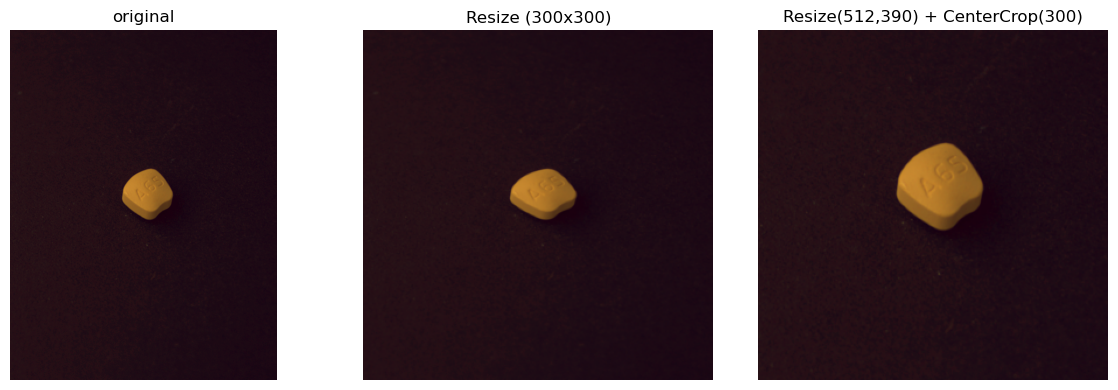

In [6]:
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# === 테스트할 이미지 경로 (원하는 이미지 경로로 수정해줘)
image_path = r"E:/dataset/dataset_classification/train/K-039148/K-039148_0_0_0_0_60_020_200.png"

# === 원본 이미지 불러오기
img = Image.open(image_path).convert("RGB")

# === 전처리 정의
resize_only = transforms.Resize((300, 300))
resize_crop = transforms.Compose([
    transforms.Resize((512, 390)),
    transforms.CenterCrop(300)
])

# === 변환 적용
resized_img = resize_only(img)
resized_crop_img = resize_crop(img)

# === 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("original")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(resized_img)
plt.title("Resize (300x300)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(resized_crop_img)
plt.title("Resize(512,390) + CenterCrop(300)")
plt.axis("off")

plt.tight_layout()
plt.show()
